In [ ]:

import importlib.util
import matplotlib.animation as animation
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c
from IPython.display import display, Math
from functools import partial

from pydantic import validate_call

import gdsfactory as gf

In [ ]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

In [ ]:
lumapiFile = r"C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)
ict_api = lumapi.INTERCONNECT(hide = False)

In [ ]:
ict_api.expressioncheckoff()

In [ ]:
um = 1e-6
nm = 1e-9

In [76]:
ng_ideal = 4.3458
ng_pdk = 4.19088
neff = 2.3531
neff_pdk = 2.44553
L = 5 * um
lambda_0 = 1546.363 * nm
#fsr_ofc = 1.6

power_couplings1 = [0.5, 0.13, 0.12, 0.5]

def delay_length(cascate,horizontal_section,mzi,fsr_ofc,ng):
    
    
    dl_base = (lambda_0**2 / (2*fsr_ofc * nm * ng))*(2**(cascate-3))
    dl_pi = (lambda_0 / neff)
    
    match horizontal_section*(cascate**2):
        case 0: shift = 0
        case 1: shift = 0.25
        case 2: shift = 0.125
        case 3: shift = 0.375
        case 4: shift = 0.75

    Delay_Length=dl_base+(dl_pi*shift)
    
    match mzi:
        case 0: dl = Delay_Length
        case 1: dl = 2*Delay_Length
        case 2: dl = 2*Delay_Length+dl_pi
    
    return(dl)


In [68]:
def delay_print(fsr,ng):

    X = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}
    Y = {0: 0, 1: -1, 2: 1, 3: -2, 4: -1, 5: 1, 6: 2}
    power_couplings2 = [0.5, 0.29, 0.08]
    coupling_length = [17.5*um,12.5*um,5*um]
    print(L/um)

    for n in range (4):           
        x= X[n+3]
        y= Y[n+3]
        for i in range (2):

            print((delay_length(1,n,i,fsr,ng)/um))

            if i>0:
                print((delay_length(1,n,i,fsr,ng)/um))

                        
    for n in range (2):
        
        x= X[n+1]
        y= Y[n+1]

        for i in range (2):

            print((delay_length(2,n,i,fsr,ng)/um))

            
            if i>0:

                print((delay_length(2,n,i,fsr,ng)/um))

                
                

        
    for i in range (2):

        print((delay_length(3,0,i,fsr,ng)/um))


        if i>0:

            print((delay_length(3,0,i,fsr,ng)/um))

delay_print(0.4,ng_ideal)

5.0
171.95039806889704
343.9007961377941
343.9007961377941
172.11468804807342
344.22937609614684
344.22937609614684
172.03254305848523
344.06508611697046
344.06508611697046
172.19683303766166
344.3936660753233
344.3936660753233
343.9007961377941
687.8015922755882
687.8015922755882
344.3936660753233
688.7873321506466
688.7873321506466
687.8015922755882
1375.6031845511764
1375.6031845511764


# Ideal MZI simulation

## Making the circuit

In [82]:
def lattice_filter(fsr,Coupler,Straight_Waveguide,ng,neff,TE_gain,lenght_name,port):

    X = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}
    Y = {0: 0, 1: -1, 2: 1, 3: -2, 4: -1, 5: 1, 6: 2}
    power_couplings2 = [0.5, 0.29, 0.08]
    coupling_length = [17.5*um,12.5*um,5*um]

    ict_api.switchtodesign()

    ict_api.deleteall()


    ict_api.addelement("Optical Network Analyzer")
    ict_api.set("name","ONA")
    ict_api.set("number of points",10000)
    ict_api.set("input parameter",2)
    ict_api.set("start frequency",c/(1500*nm))
    ict_api.set("stop frequency",c/(1600*nm))
    ict_api.setposition("ONA",0,0)
    ict_api.set("number of input ports", 8)

    for n in range (4):           
        x= X[n+3]
        y= Y[n+3]
        for i in range (2):
            
            ict_api.addelement(Coupler)
            ict_api.set("name",f"splitterC{n}{i}")
            if (ng==ng_pdk):
                ict_api.set("coupling_length",coupling_length[i])
            else:
                ict_api.set("coupling coefficient 1",power_couplings2[i])
                ict_api.set("coupling coefficient 2",power_couplings2[i])
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvgC{n}{i}")
            if (ng!=ng_pdk):
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L+delay_length(1,n,i,fsr,ng))
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg2C{n}{i}")
            if (ng!=ng_pdk):
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L)#delay_length(cascate,horizontal_section,mzi,fsr_ofc,,ng)
            
            xs = -1000 +1400*x + (i*400)
            ys = +1500 + y*(1500/4)
            xc=xs+400
            yc=ys
            xw1=xs+200
            yw1=ys-100
            xw2=xw1
            yw2= ys+100 
            ict_api.setposition(f"splitterC{n}{i}",xs,ys)
            ict_api.setposition(f"wvgC{n}{i}",xw1,yw1)
            ict_api.setposition(f"wvg2C{n}{i}",xw2,yw2)
            
            ict_api.connect(f"splitterC{n}{i}", f"{port}3", f"wvgC{n}{i}", "port 1")
            ict_api.connect(f"splitterC{n}{i}", f"{port}4", f"wvg2C{n}{i}", "port 1")
            if i>0:
                ict_api.connect(f"wvgC{n}{i-1}", "port 2", f"splitterC{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2C{n}{i-1}", "port 2", f"splitterC{n}{i}", f"{port}2")
                ict_api.select(f"wvgC{n}{i}")
                ict_api.set(lenght_name,L)
                ict_api.select(f"wvg2C{n}{i}")
                ict_api.set(lenght_name,L+delay_length(1,n,i,fsr,ng))
            if i==1:
                ict_api.addelement(Coupler)
                ict_api.set("name",f"combinerC{n}{i}")
                ict_api.setposition(f"combinerC{n}{i}",xc,yc)   
                if (ng==ng_pdk):
                    ict_api.set("coupling_length",coupling_length[i+1])
                else:
                    ict_api.set("coupling coefficient 1",power_couplings2[i+1])
                    ict_api.set("coupling coefficient 2",power_couplings2[i+1])
                ict_api.connect(f"wvgC{n}{i}", "port 2", f"combinerC{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2C{n}{i}", "port 2", f"combinerC{n}{i}", f"{port}2")
                ict_api.connect(f"combinerC{n}{i}", f"{port}3","ONA", f"input {2*n+1}")
                ict_api.connect(f"combinerC{n}{i}", f"{port}4","ONA", f"input {2*n+2}")

                        
    for n in range (2):
        
        x= X[n+1]
        y= Y[n+1]

        for i in range (2):
            ict_api.addelement(Coupler)
            ict_api.set("name",f"splitterB{n}{i}")   
            if (ng==ng_pdk):
                ict_api.set("coupling_length",coupling_length[i])
            else:
                ict_api.set("coupling coefficient 1",power_couplings2[i])
                ict_api.set("coupling coefficient 2",power_couplings2[i]) 
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvgB{n}{i}")    
            if (ng!=ng_pdk):            
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L+ delay_length(2,n,i,fsr,ng))
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg2B{n}{i}")
            if (ng!=ng_pdk):
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L )
            
            xs = -1000 +1400*x + (i*400)
            ys = +1500 + y*(1500/3)
            xc=xs+400
            yc=ys
            xw1=xs+200
            yw1=ys-100
            xw2=xw1
            yw2= ys+100
            
            ict_api.setposition(f"splitterB{n}{i}",xs,ys)
            ict_api.setposition(f"wvgB{n}{i}",xw1,yw1)
            ict_api.setposition(f"wvg2B{n}{i}",xw2,yw2)
            
            ict_api.connect(f"splitterB{n}{i}", f"{port}3", f"wvgB{n}{i}", "port 1")
            ict_api.connect(f"splitterB{n}{i}", f"{port}4", f"wvg2B{n}{i}", "port 1")
            
            if i>0:
                ict_api.connect(f"wvgB{n}{i-1}", "port 2", f"splitterB{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2B{n}{i-1}", "port 2", f"splitterB{n}{i}", f"{port}2")
                ict_api.select(f"wvgB{n}{i}")
                ict_api.set(lenght_name,L)
                ict_api.select(f"wvg2B{n}{i}")
                ict_api.set(lenght_name,L+delay_length(2,n,i,fsr,ng))
                

            if i==1:
                ict_api.addelement(Coupler)
                ict_api.set("name",f"combinerB{n}{i}")
                ict_api.setposition(f"combinerB{n}{i}",xc,yc)   
                if (ng==ng_pdk):
                    ict_api.set("coupling_length",coupling_length[i+1])
                else:
                    ict_api.set("coupling coefficient 1",power_couplings2[i+1])
                    ict_api.set("coupling coefficient 2",power_couplings2[i+1])
                ict_api.connect(f"wvgB{n}{i}", "port 2", f"combinerB{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2B{n}{i}", "port 2", f"combinerB{n}{i}", f"{port}2")
                ict_api.connect(f"combinerB{n}{i}", f"{port}3",f"splitterC{2*n}0",f"{port}2")
                ict_api.connect(f"combinerB{n}{i}", f"{port}4",f"splitterC{2*n+1}0", f"{port}1")
                
                

        
    for i in range (2):
        
        ict_api.addelement(Coupler)
        ict_api.set("name",f"splitterA{i}")   
        if (ng==ng_pdk):
            ict_api.set("coupling_length",coupling_length[i])
        else:
            ict_api.set("coupling coefficient 1",power_couplings2[i])
            ict_api.set("coupling coefficient 2",power_couplings2[i])
        ict_api.addelement(Straight_Waveguide)
        ict_api.set("name",f"wvgA{i}")
        if (ng!=ng_pdk):
            ict_api.set("effective index 1",neff)
            ict_api.set("group index 1",ng)
        ict_api.set(lenght_name,L+delay_length(3,0,i,fsr,ng))
        ict_api.addelement(Straight_Waveguide)
        ict_api.set("name",f"wvg2A{i}")
        if (ng!=ng_pdk):
            ict_api.set("effective index 1",neff)
            ict_api.set("group index 1",ng)
        ict_api.set(lenght_name,L)
        
        xs = -1000 + (i*400)
        ys = +1500 
        xc=xs+400
        yc=ys
        xw1=xs+200
        yw1=ys-100
        xw2=xw1
        yw2= ys+100
        
        ict_api.setposition(f"splitterA{i}",xs,ys)
        ict_api.setposition(f"wvgA{i}",xw1,yw1)
        ict_api.setposition(f"wvg2A{i}",xw2,yw2)
        
        ict_api.connect(f"splitterA{i}", f"{port}3", f"wvgA{i}", "port 1")
        ict_api.connect(f"splitterA{i}", f"{port}4", f"wvg2A{i}", "port 1")
        
        if i>0:
            ict_api.connect(f"wvgA{i-1}", "port 2", f"splitterA{i}", f"{port}1")
            ict_api.connect(f"wvg2A{i-1}", "port 2", f"splitterA{i}", f"{port}2")
            ict_api.select(f"wvgA{i}")
            ict_api.set(lenght_name,L)#delay_length(cascate,horizontal_section,mzi,fsr_ofc,,ng)
            ict_api.select(f"wvg2A{i}")
            ict_api.set(lenght_name,L+delay_length(3,0,i,fsr,ng))

        if i==1:
            ict_api.addelement(Coupler)
            ict_api.set("name",f"combinerA{i}")
            ict_api.setposition(f"combinerA{i}",xc,yc)   
            if (ng==ng_pdk):
                ict_api.set("coupling_length",coupling_length[i+1])
            else:
                ict_api.set("coupling coefficient 1",power_couplings2[i+1])
                ict_api.set("coupling coefficient 2",power_couplings2[i+1])
            ict_api.connect(f"wvgA{i}", "port 2", f"combinerA{i}", f"{port}1")
            ict_api.connect(f"wvg2A{i}", "port 2", f"combinerA{i}", f"{port}2")
            ict_api.connect(f"combinerA{i}", f"{port}3",f"splitterB00", f"{port}2")
            ict_api.connect(f"combinerA{i}", f"{port}4",f"splitterB10", f"{port}1")
            
        
    ict_api.connect("splitterA0", f"{port}2","ONA", "output")
    
    ict_api.switchtodesign()
    ict_api.run()
        
    plt.figure(figsize=(10,6))  # Tamanho do gráfico

    for input in range(8):
        wavelength = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")['wavelength']
        te_gain_db = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")[TE_gain]
        plt.plot(wavelength*1e9, te_gain_db, label=f'Input {input+1}')  # X em nm

    # Configurações atualizadas
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(TE_gain)
    plt.title('Lattice Filter - All Inputs')
    plt.grid(True)
    plt.legend()
    plt.xlim(1540, 1560)  # Novo limite X
    plt.ylim(-15,0)    # Novo limite Y
    plt.show()

In [ ]:
# Parameters
gap = 0.2e-6;        # 0.2 µm
wg_width = 0.5e-6;   # 0.5 µm
wavelength = 1.55e-6;
L_c = 17.5e-6;

# Define waveguide geometry (you may use GUI for this too)
ict_api.addelement('ebeam_wg_integral_1550')
ict_api.set("wg_width", wg_width);
ict_api.setposition ('ebeam_wg_integral_1550_2', +gap/2 + wg_width/2,0);
ict_api.addelement('ebeam_wg_integral_1550')
ict_api.set("wg_width", wg_width);
ict_api.setposition ('ebeam_wg_integral_1550_2', +gap/2 + wg_width/2,0);

# Run mode analysis
ict_api.findmodes

# Extract effective indices
n_even = ict_api.getdata("FDE::data", "neff")[1];
n_odd  = ict_api.getdata("FDE::data", "neff")[2];

# Compute coupling coefficient
kappa = (3.14159 / wavelength) * abs(n_even - n_odd);
?("Coupling coefficient (κ) = " + num2str(kappa) + " rad/m");


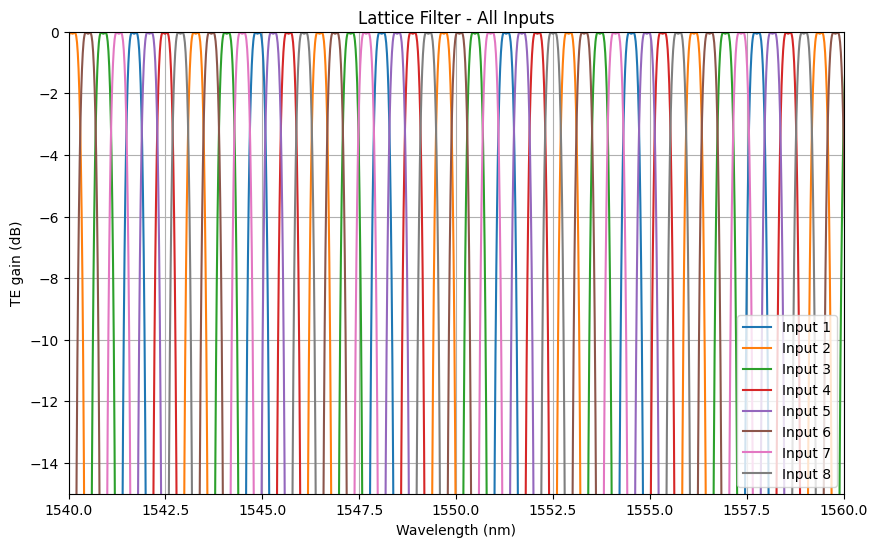

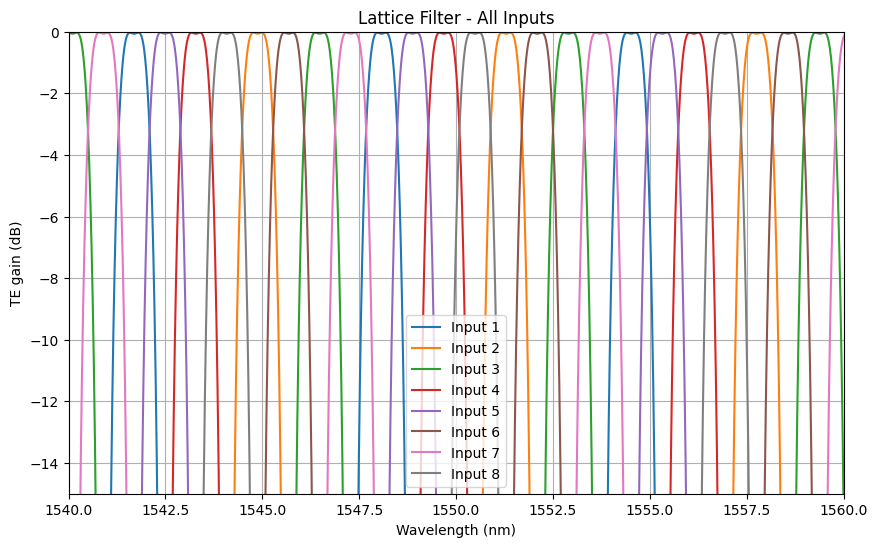

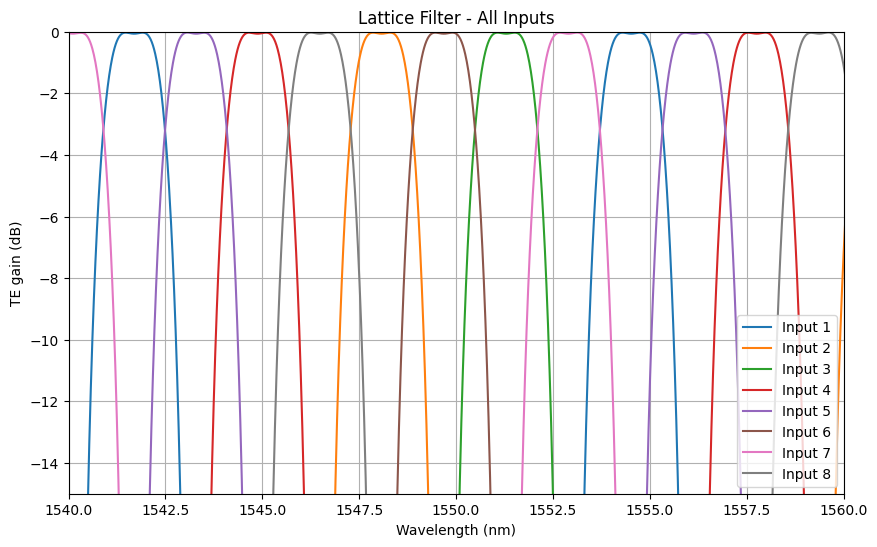

In [73]:
lattice_filter(0.4,"Waveguide Coupler","Straight waveguide",ng_ideal,neff,'TE gain (dB)','length','port ')
lattice_filter(0.8,"Waveguide Coupler","Straight waveguide",ng_ideal,neff,'TE gain (dB)','length','port ')
lattice_filter(1.6,"Waveguide Coupler","Straight waveguide",ng_ideal,neff,'TE gain (dB)','length','port ')

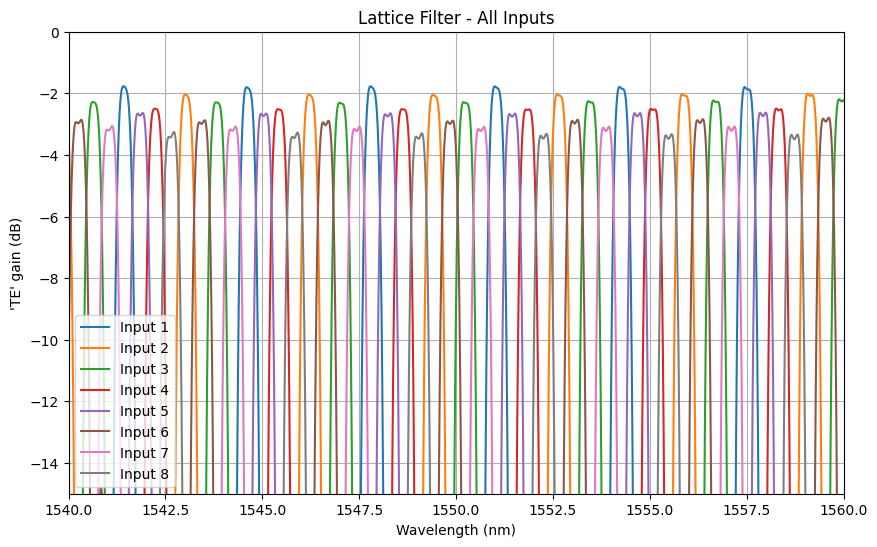

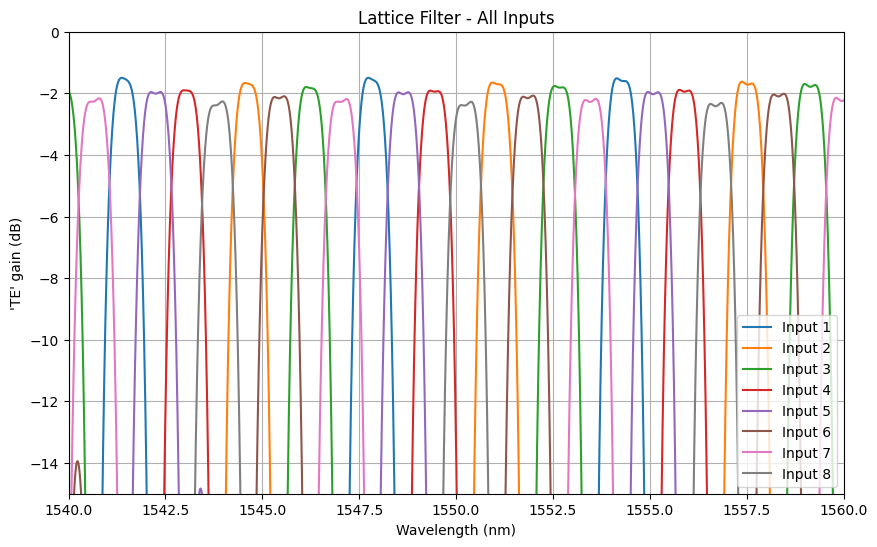

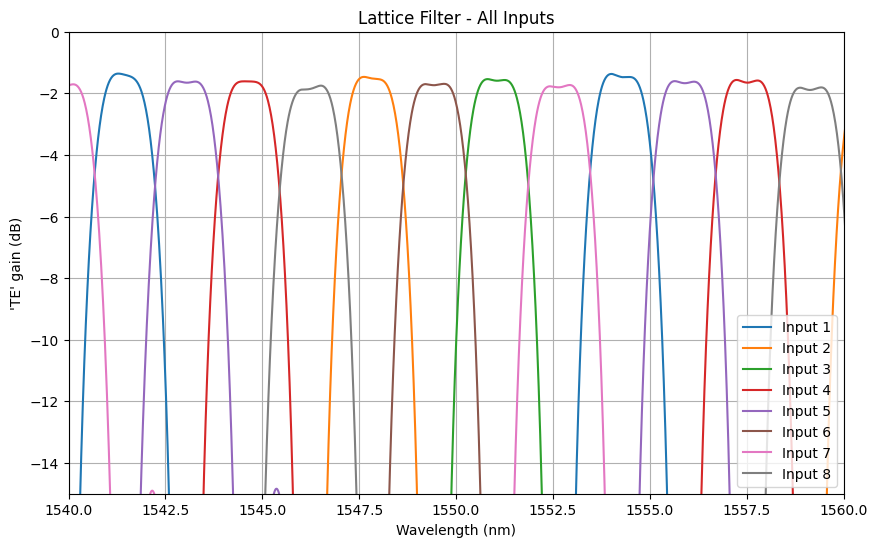

In [84]:
lattice_filter(0.4,"ebeam_dc_te1550",'ebeam_wg_integral_1550',ng_pdk,neff_pdk,"'TE' gain (dB)",'wg_length','opt_')
lattice_filter(0.8,"ebeam_dc_te1550",'ebeam_wg_integral_1550',ng_pdk,neff_pdk,"'TE' gain (dB)",'wg_length','opt_')
lattice_filter(1.6,"ebeam_dc_te1550",'ebeam_wg_integral_1550',ng_pdk,neff_pdk,"'TE' gain (dB)",'wg_length','opt_')